<a href="https://colab.research.google.com/github/juanestebanperezm/Red_antagonica_generativa_convolucional/blob/main/Red_antagonica_generativa_convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_l0j7oh8
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_l0j7oh8
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=318a915bb7bb1e0414ab80cd8a38189ae25855cd0bcf32cef4b1983a1f300250
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7ngq0t6/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np 
import os 
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
from IPython import display

In [4]:
(train_images,test_images),(_,_)=keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
#Normalizacion de imagenes
train_images=(train_images-127.5)/127.5

BUFFER_SIZE=60000
BATCH_SIZE=256

In [6]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<h1>🎇🧨🎃🎆🎭 ;)

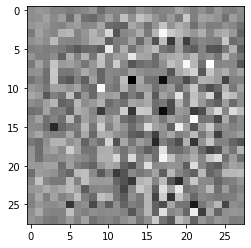

In [8]:
#Modelo Artista 
def generador_():
  
  #Parte inicial de la red neuronal, donde ingresan datos, se normalizan y se implementa una f(x) de activacion
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  return model 





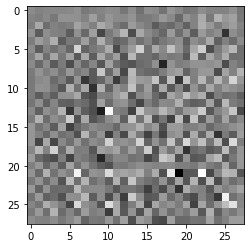

In [37]:
generator=generador_()

nose=tf.random.normal([1,100])
imagen_generada=generator(nose,training=False)

plt.imshow(imagen_generada[0,:,:,0],cmap='gray')

In [38]:
def discriminador():
  modelo=keras.Sequential()
  modelo.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))

  modelo.add(layers.LeakyReLU())
  modelo.add(layers.Dropout(0.3))

  modelo.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  modelo.add(layers.LeakyReLU())
  modelo.add(layers.Dropout(0.3))

  modelo.add(layers.Flatten())
  modelo.add(layers.Dense(1))

  return modelo

<h1>Loss & Optimizers  : Perdida y Optimizacion</h1>

In [39]:
cross_entropy=keras.losses.BinaryCrossentropy(from_logits=True)

<h1>Perdida del Discriminador<h1>

In [40]:
def perdida_discriminador(real_output,fake_output):
  
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  
  return real_loss + fake_loss

<h1>Perdida del generador<h1>

In [41]:
def perdida_generador(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [42]:
generator_optimizer=keras.optimizers.Adam(1e-4)
discriminator_optimizer=keras.optimizers.Adam(1e-4)

<h1>Puntos de control</h1>

In [45]:
discriminator=discriminador()
descision=discriminator(imagen_generada)


checkpoint_dir='/content/checkpoints'
check_point_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                              generator=generator,
                              discriminator=discriminator)

<h1>Ciclo de entrenamiento, generaciones, tamaño de batch </h1>

In [100]:
EPOCHS=500
noise_dim=100
num_examples_to_generate=16

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [101]:
@tf.function
def train_step(images):
  
  noise=tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    gen_loss=perdida_generador(fake_output)
    disc_loss=perdida_discriminador(real_output,fake_output)
  
  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [102]:
def train(dataset,epochs):
  for epoch in range(EPOCHS):
    start=time.time()

  for image_batch in dataset:
    train_step(image_batch)

  display.clear_output(wait=True)
  generate_and_save_images(generator,epoch+1,seed)

  if (epoch+1)%15==0:
    checkpoint.save(file_prefix=checkpoint_prefix)
  print('Tiempo por epoch {} es {} segundos'.format(epoch+1,time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [103]:
def generate_and_save_images(model,epoch,test_input):
  
  predictions=model(test_input,training=False)

  fig=plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')
  
  plt.savefig('imagen_en_epoch{:04d}.png'.format(epoch))
  plt.show()

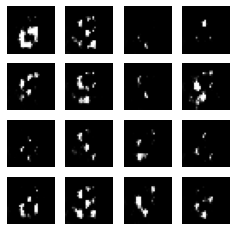

In [104]:
train(train_dataset,EPOCHS)

In [105]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<h1>Gif</h1>

In [112]:
def display_image(epoch_no):
  return PIL.Image.open('/content/imagen_en_epoch0200.png')

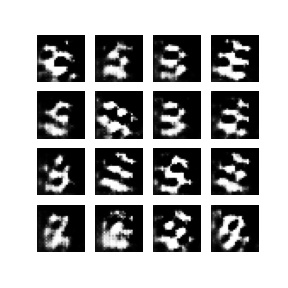

In [113]:
display_image(EPOCHS)

In [114]:
anim_file='dcgan.gif'

with imageio.get_writer(anim_file,mode='I') as writer:
  filenames=glob.glob('image*.png')
  filenames=sorted(filenames)
  for filename in filenames:
    image=imageio.imread(filename)
    writer.append_data(image)
  image=imageio.imread(filename)
  writer.append_data(image)


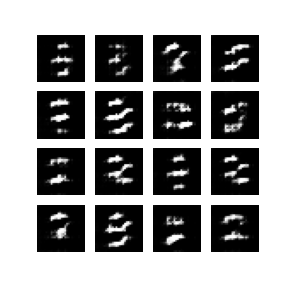

In [115]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)